In [11]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pandas as pd
from IPython.display import display
pd.set_option('max_colwidth', 70)
pd.set_option('display.max_rows', 500)
import string
import numpy as np
import matplotlib.pyplot as plt

from orangecontrib.bioinformatics.geneset.__init__ import list_all

import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from networks.functionsDENet import loadPickle, savePickle
import enrichment_library as enr
reload(enr)
import enrichment_library as enr
from stages_DE.stages_library import PHENOTYPES

In [2]:
#Path for expression data (mergedGenes_RPKUM.tsv)
dataPath='/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
path_abberant='/home/karin/Documents/timeTrajectories/data/regulons/selected_genes/'

In [3]:
# For conversion of gene names to EID
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
all_gene_names= genes[(genes != 0).any(axis=1)].index
NAME_EID=enr.name_genes_entrez(gene_names=all_gene_names, key_entrez=False)
ALL_GENE_NAMES_EID=enr.convert_EID(genes=all_gene_names, name_EID=NAME_EID)

In [30]:
def group_diff_enrichment(query_names,group:str,padj:float=0.25,min_overlap:int=None,
                          use_annotated_genes:bool=False):
    #Displays only gene sets that have overlap with query greater or equal to min_overlap 
    #For p value and padj calculation uses alll that have overlap >=1 } from gene_set_enrichment
    """
    :param use_annotated_genes: if True use for reference and query  only genes that have at 
    least one gene set annotation
    """
    query_EID=enr.convert_EID(genes=query_names, name_EID=NAME_EID)
    print('***  '+group+' selected:',len(query_names),'with EID:',len(query_EID))
    
    reference_gene_eids=ALL_GENE_NAMES_EID.copy()
    query_eids=query_EID.copy()
    
    if use_annotated_genes:
        gene_sets_genes=set()
        for gene_set_name, gene_sets in GENE_SETS_ONTOLOGY.items():
            for gene_set in gene_sets:
                gene_sets_genes.update(gene_set.genes)
        reference_gene_eids=set(reference_gene_eids) & gene_sets_genes
        query_eids=set(query_eids) & gene_sets_genes
        
        query_annotated_reatio='NA'
        if len(query_EID)>0:
            query_annotated_reatio=round(len(query_eids)/len(query_EID),2)
        print('Ratio of genes annotated with a gene set in reference',
              round(len(reference_gene_eids)/len(ALL_GENE_NAMES_EID),2),
             'and query',query_annotated_reatio)
    
    query_in_enriched=set()
    result=None
    if len(query_eids) > 0:
        enrichment=enr.gene_set_enrichment(query_eids, reference_EID=reference_gene_eids, 
                                                padj_threshold=padj,min_overlap=min_overlap,
                                                gene_sets_ontology=GENE_SETS_ONTOLOGY)
        if len(enrichment)>0:
            enrichment_display=list()
            enrichment= sorted(enrichment, key=lambda data: data.padj)
            for enriched in enrichment:
                query_in_enriched.update(enriched.gene_set.genes & query_eids)
                enrichment_display.append({'Gene set':enriched.gene_set.name,
                                           'Ontology':enriched.ontology[0]+': '+enriched.ontology[1],
                                           'FDR':"{:.2e}".format(enriched.padj),'N in query':enriched.in_query,
                                          'Set size':len(enriched.gene_set.genes),
                                                          'N in ref.':enriched.in_reference})
            result=pd.DataFrame(enrichment_display)
    print('Enrichment at FDR: '+str(padj)+' and min query - gene set overlap',str(min_overlap))
    print('N query genes in displayed gene sets:',len(query_in_enriched),'out of', len(query_eids),
          'query genes used for enrichment calculation.')
    display(result)
    print('\n')
    return result

In [4]:
comparison_order=('agg-','dis','tag','cud')

## Enrichment report

Filter results based on FDR (<=0.05) and Difference between group means (>=0.3).

In [20]:
#Enrichment
PADJ=0.25
MIN_OVERLAP=2
MAX_FE_BAR=30
MIN_FDR_BAR=10**(-10)
LFDR_BASE_BAR=10
# Any colour map from https://matplotlib.org/tutorials/colors/colormaps.html
#CMAP_FDR_BAR='gnuplot'
CMAP_FDR_BAR=['#000000',"#171082", "#6d00b0",'#a1239f', "#b0003e",'#b01a00','#cc6300','#eb9202','#d4a600','#e3dc12']

In [5]:
abberant=pd.read_table(
    path_abberant+'comparisonsAvgSimsSingle2STDAny0.2_lessComparisons2_AX4basedNeigh_u-less_newGenes_noAll-removeZeroRep_simsDict_scalemean0std1_logTrue_kN11_splitStrain.tsv',
                       index_col=0,sep='\t')
abberant=abberant[(abberant['Difference mean']>=0.3) & (abberant['FDR']<=0.05)]

### KEGG, DictyPhenotypes, GO slims

In [21]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
GENE_SETS_ONTOLOGY=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=True,set_sizes=(5,500))

In [22]:
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in GENE_SETS_ONTOLOGY.items():
    for s in v:
        n=len(s.genes)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in GENE_SETS_ONTOLOGY.items()})   

Min size 5 Max size 495
N sets {('GO', 'biological_process'): 52, ('GO', 'molecular_function'): 35, ('GO', 'cellular_component'): 24, ('KEGG', 'Pathways'): 96, ('Dictybase', 'Phenotypes'): 209, ('Custom', 'Baylor'): 13}


***  agg- selected: 162 with EID: 160
Ratio of genes annotated with a gene set in reference 0.38 and query 0.55
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 65 out of 88 query genes used for enrichment calculation.


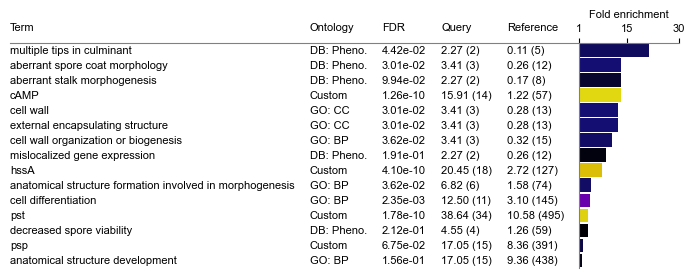

***  dis selected: 550 with EID: 549
Ratio of genes annotated with a gene set in reference 0.38 and query 0.5
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 201 out of 276 query genes used for enrichment calculation.


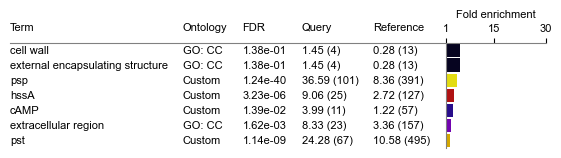

***  tag selected: 39 with EID: 39
Ratio of genes annotated with a gene set in reference 0.38 and query 0.59
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 15 out of 23 query genes used for enrichment calculation.


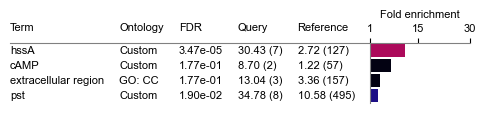

***  cud selected: 517 with EID: 510
Ratio of genes annotated with a gene set in reference 0.38 and query 0.32
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 80 out of 161 query genes used for enrichment calculation.


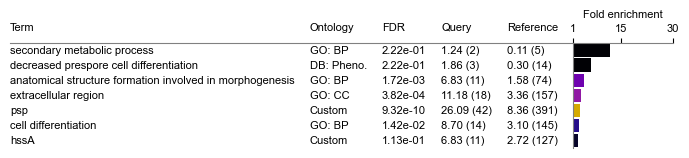

In [23]:
%matplotlib agg
figs=[]
for comparison in comparison_order:
    query_names=list(abberant.query('Comparison == "'+comparison+'"').index)

    enriched=enr.group_diff_enrichment(query_names=query_names,
                                       group=comparison,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
plt.close('all')    

### KEGG, DictyPhenotypes, GO 

In [24]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
GENE_SETS_ONTOLOGY=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=False,set_sizes=(5,500))

In [25]:
# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in GENE_SETS_ONTOLOGY.items():
    for s in v:
        n=len(s.genes)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in GENE_SETS_ONTOLOGY.items()})  

Min size 5 Max size 495
N sets {('GO', 'biological_process'): 1379, ('GO', 'molecular_function'): 424, ('GO', 'cellular_component'): 305, ('KEGG', 'Pathways'): 96, ('Dictybase', 'Phenotypes'): 209, ('Custom', 'Baylor'): 13}


***  agg- selected: 162 with EID: 160
Ratio of genes annotated with a gene set in reference 0.39 and query 0.58
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 69 out of 93 query genes used for enrichment calculation.


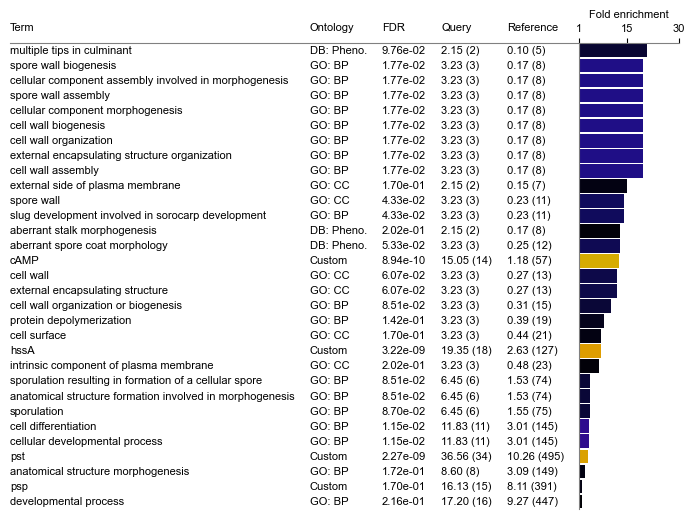

***  dis selected: 550 with EID: 549
Ratio of genes annotated with a gene set in reference 0.39 and query 0.51
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 206 out of 282 query genes used for enrichment calculation.


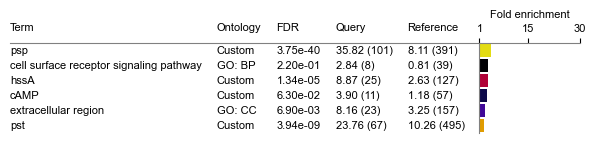

***  tag selected: 39 with EID: 39
Ratio of genes annotated with a gene set in reference 0.39 and query 0.59
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 14 out of 23 query genes used for enrichment calculation.


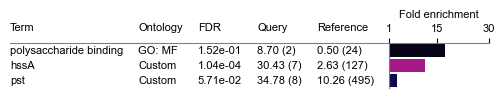

***  cud selected: 517 with EID: 510
Ratio of genes annotated with a gene set in reference 0.39 and query 0.33
Enrichment at FDR: 0.25 and min query - gene set overlap 2
N query genes in displayed gene sets: 86 out of 166 query genes used for enrichment calculation.


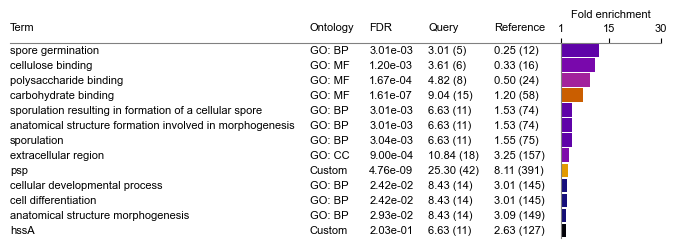

In [26]:
%matplotlib agg
figs=[]
for comparison in comparison_order:
    query_names=list(abberant.query('Comparison == "'+comparison+'"').index)

    enriched=enr.group_diff_enrichment(query_names=query_names,
                                       group=comparison,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
plt.close('all')    